# Reads Assignment

In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from starmap.sequencing import *
from natsort import natsorted
from scipy.io import loadmat, savemat
from skimage.filters import threshold_otsu
from skimage.color import label2rgb
from tqdm import tqdm

### Functions

In [2]:
from functools import wraps
from time import time

# Timer
def timer(func):
    @wraps(func)
    def _time_it(*args, **kwargs):
        start = int(round(time() * 1000))
        try:
            return func(*args, **kwargs)
        finally:
            end_ = int(round(time() * 1000)) - start
            end_ = round(end_ / 1000, 4)
            print(f"Total execution time: {end_ if end_ > 0 else 0} s")
    return _time_it


@timer
# Load reads and their positions from mat file
def load_reads(fpath, reads_file):
    S = loadmat(os.path.join(fpath, reads_file))
    bases = [str(i[0][0]) for i in S["merged_reads"]]
    points = S["merged_points"]
    temp = np.zeros(points.shape)
    temp[:, 0] = np.round(points[:, 1]-1)
    temp[:, 1] = np.round(points[:, 0]-1)
    temp[:, 2] = np.round(points[:, 2]-1)
    
    print(f"Number of reads: {len(bases)}")
    
    return bases, temp


# Load gene table from genes.csv
def load_genes(fpath):
    genes2seq = {}
    seq2genes = {}
    with open(os.path.join(fpath, "genes.csv"), encoding='utf-8-sig') as f:
        for l in f:
            fields = l.rstrip().split(",")
            genes2seq[fields[0]] = "".join([str(s+1) for s in encode_SOLID(fields[1][::-1])])
            seq2genes[genes2seq[fields[0]]] = fields[0]
    return genes2seq, seq2genes

## Input

In [3]:
# IO path 
base_path = 'Z:/Data/Analyzed/2021-05-02-Rena-Hela-EU/'
out_path = os.path.join(base_path, 'output')
if not os.path.exists(out_path):
    os.mkdir(out_path)
    
sample_dict = {'20h_labeling': '20h labeling',
               '1h_labeling_6h_wash': '1h labeling, 6h wash',
               '1h_labeling_4h_wash': '1h labeling, 4h wash',
               '1h_labeling_2h_wash': '1h labeling, 2h wash',
               '1h_labeling_1h_wash': '1h labeling, 1h wash',
               '1h_labeling': '1h labeling'}
sample_dirs = list(sample_dict.keys())

## Run pipeline for individual sample

In [61]:
# Iterate through each sample dir
current_dir = sample_dirs[0]
# print(test_dir)

print(f"Current sample: {current_dir}")

# Load genes
genes2seqs, seqs2genes = load_genes(base_path)

# Load reads 
bases, points = load_reads(os.path.join(base_path, current_dir), "merged_goodPoints_max3d.mat")
bases = np.array(bases)
points = np.array(points)

Current sample: 20h_labeling
Number of reads: 2153334
Total execution time: 18.653 s


In [62]:
# structure_dict = {'whole_cell': 'cell.tif'}

structure_dict = {'whole_cell': 'cell.tif',
                 'nucleus': 'nuclei.tif',
                 'cytoplasm': 'cyto.tif',
                 'outer_cytoplasm': 'outer_cyto.tif',
                 'er': 'er.tif'}

total_cells = None
expr_out_path = os.path.join(out_path, current_dir)
if not os.path.exists(expr_out_path):
    os.mkdir(expr_out_path)
        
expr_dict = {}
for current_structure in structure_dict.keys():
    print(f"====Processing: {current_structure}====")
    # Path

    # Load segmentation
    current_seg = load_label_image(os.path.join(base_path, current_dir), fname=structure_dict[current_structure])

    # Load image
    current_img = load_label_image(os.path.join(base_path, current_dir), fname='overlay_label.tiff')
    
    # Set figsize
    figsize = (np.floor(current_img.shape[1] / 1000 * 5), np.floor(current_img.shape[0] / 1000 * 5))

#     # Plot cell number 
#     t_size = 10
#     plt.figure(figsize=figsize)
#     plt.imshow(current_img > 0)
#     for i, region in enumerate(regionprops(current_seg)):
#         plt.plot(region.centroid[1], region.centroid[0], '.', color='red', markersize=4)
#         plt.text(region.centroid[1], region.centroid[0], str(region.label - 1), fontsize=t_size, color='red')
#     plt.axis('off')
#     plt.savefig(os.path.join(seg_path, f"cell_nums_{current_structure}.png"))
#     plt.clf()
#     plt.close()
    
    if current_structure == 'whole_cell':
        # Plot dots on segmentation mask
        plt.figure(figsize=figsize)
        plt.imshow(current_img > 0, cmap='gray')
        plt.plot(points[:, 1], points[:, 0], '.', color='red', markersize=1)
        plt.axis('off')
        print(f"Saving points_seg.png")
        plt.savefig(os.path.join(expr_out_path, f"points_seg_{current_structure}.png"))
        plt.clf()
        plt.close()
    
    
    # Reads assignment to current_structure
    current_out_path = os.path.join(expr_out_path, current_structure)
    if not os.path.exists(current_out_path):
        os.mkdir(current_out_path)

    points = points.astype(int)
    reads_assignment = current_seg[points[:, 2], points[:, 0], points[:, 1]]

    reads_info = pd.DataFrame({'x':points[:, 0], 'y':points[:, 1], 'z':points[:, 2], 'cell_label':reads_assignment})
    reads_info = reads_info.astype(np.int32)
    reads_info['orig_index'] = reads_info['cell_label'] - 1
    reads_info['gene'] = bases
    
    reads_info.to_csv(os.path.join(current_out_path, 'reads-info.csv'))
    
    if not total_cells:
        total_cells = len(np.unique(current_seg)) - 1
        print(f"Total number of cells: {total_cells}")

    genes = genes2seqs.keys()
    cell_by_barcode = np.zeros((total_cells, len(genes)))
    genes_to_index = {}  # map from sequence to index into matrix

    for i, k in enumerate(genes):
        genes_to_index[k] = i
        
    # Get region information 
    print('Getting region information...')
    region_labels = []
    areas_dict = []
    cell_locs_dict = []
    for i, region in enumerate(tqdm(regionprops(current_seg))):
        # print(region.label)
        region_labels.append(region.label)
        areas_dict.append(region.area)
        cell_locs_dict.append(region.centroid)
        
#         areas_dict[region.label] = region.area
#         cell_locs_dict[region.label] = region.centroid
    
    # Iterate through cells
    print('Iterate cells...')
    areas = []
    cell_locs = []
    for i in tqdm(range(total_cells)):
        current_label = i+1
        if current_label in region_labels:
            areas.append(areas_dict[region_labels.index(current_label)])
            cell_locs.append(cell_locs_dict[region_labels.index(current_label)])
        else:
            areas.append(0)
            cell_locs.append([0, 0, 0])
            
        assigned_reads = bases[np.argwhere(reads_assignment == current_label).flatten()]
        for j in assigned_reads:
            if j in genes_to_index:
                cell_by_barcode[i, genes_to_index[j]] += 1

    cell_locs = np.array(cell_locs).astype(int)
    curr_meta = pd.DataFrame({'sample': current_dir, 'volume': areas,
                              'x':cell_locs[:, 1], 'y':cell_locs[:, 2], 'z':cell_locs[:, 0]})

    # Output
    with open(os.path.join(current_out_path, "log.txt"), 'w') as f:
        msg = "{:.2%} percent [{} out of {}] reads were assigned to {} cells".format(cell_by_barcode.sum()/len(bases), cell_by_barcode.sum(), len(bases), total_cells)
        print(msg)
        f.write(msg)
    np.savetxt(os.path.join(current_out_path, "cell_barcode_count.csv"), cell_by_barcode.astype(np.int), delimiter=',', fmt="%d")
    cell_barcode_names = pd.DataFrame({'seq': list(seqs2genes.keys()), 'gene': list(seqs2genes.values())})
    cell_barcode_names.to_csv(os.path.join(current_out_path, "cell_barcode_names.csv"), header=False)
    curr_meta.to_csv(os.path.join(current_out_path, "meta.csv"))

    expr_dict[current_structure] = cell_by_barcode
    # print(curr_meta.head())
    # sns.distplot(areas)

====Processing: whole_cell====
Saving points_seg.png
Total number of cells: 1439
Getting region information...


  1%|▉                                                                              | 18/1439 [00:00<00:08, 173.84it/s]

Iterate cells...


100%|█████████████████████████████████████████████████████████████████████████████| 1439/1439 [00:07<00:00, 182.61it/s]


87.36% percent [1881047.0 out of 2153334] reads were assigned to 1439 cells
====Processing: nucleus====
Getting region information...


  2%|█▊                                                                             | 32/1439 [00:00<00:04, 318.23it/s]

Iterate cells...


100%|█████████████████████████████████████████████████████████████████████████████| 1439/1439 [00:06<00:00, 224.43it/s]


26.35% percent [567390.0 out of 2153334] reads were assigned to 1439 cells
====Processing: cytoplasm====
Getting region information...


  2%|█▊                                                                             | 32/1439 [00:00<00:04, 315.11it/s]

Iterate cells...


100%|█████████████████████████████████████████████████████████████████████████████| 1439/1439 [00:05<00:00, 265.35it/s]


61.03% percent [1314244.0 out of 2153334] reads were assigned to 1439 cells
====Processing: outer_cytoplasm====
Getting region information...


  2%|█▍                                                                             | 26/1439 [00:00<00:05, 256.02it/s]

Iterate cells...


100%|█████████████████████████████████████████████████████████████████████████████| 1439/1439 [00:06<00:00, 213.37it/s]


32.79% percent [706137.0 out of 2153334] reads were assigned to 1439 cells
====Processing: er====
Getting region information...


  2%|█▋                                                                             | 30/1439 [00:00<00:04, 295.41it/s]

Iterate cells...


100%|█████████████████████████████████████████████████████████████████████████████| 1439/1439 [00:05<00:00, 264.96it/s]


28.35% percent [610441.0 out of 2153334] reads were assigned to 1439 cells


In [63]:
curr_meta

,sample,volume,x,y,z
0,20h_labeling,37706,29,2495,42
1,20h_labeling,47271,46,1581,37
2,20h_labeling,32701,48,4578,35
3,20h_labeling,97197,93,9056,36
4,20h_labeling,55294,79,1278,39
...,...,...,...,...,...
1434,20h_labeling,94358,12277,851,22
1435,20h_labeling,70235,12262,2905,16
1436,20h_labeling,63556,12263,12094,17
1437,20h_labeling,30703,12292,8057,22


In [64]:
curr_meta.loc[curr_meta.volume == 0, ]

,sample,volume,x,y,z


## Check expression pattern

In [22]:
# Get assigned reads 
assigned_index = np.argwhere(reads_assignment != 0).flatten()
assigned_bases = bases[assigned_index]
assigned_points = points[assigned_index, :]

In [24]:
gene = 'MALAT1'
curr_index = np.argwhere(assigned_bases == gene).flatten()
curr_points = assigned_points[curr_index, :]
print(f"Number of reads: {curr_points.shape[0]}")

Number of reads: 2838


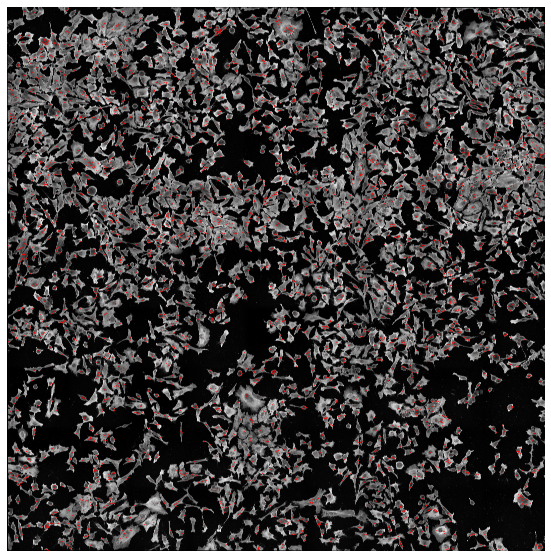

In [144]:
# Plot dots on segmentation mask
plt.figure(figsize=(10, 10))
plt.imshow(cyto, cmap='gray')
plt.plot(curr_points[:, 1], curr_points[:, 0], '.', color='red', markersize=.5)
plt.axis('off')
plt.show()

In [25]:
# Get read quantification for each gene after read assignemnt 
per_gene_expr = pd.DataFrame({'gene': list(genes), 'expr': cell_by_barcode.sum(axis=0)})
per_gene_expr = per_gene_expr.sort_values('expr', ascending=False, ignore_index=True)
per_gene_expr.head(20)

,gene,expr
0,NCAPG,21576.0
1,RPL37,15850.0
2,TSHZ1,15073.0
3,CLU,10138.0
4,YTHDF2,9437.0
5,RPS28,9289.0
6,PRPF31,7363.0
7,NFIC,6708.0
8,EEF2,6057.0
9,SRRM2,5907.0


In [146]:
selected_genes = per_gene_expr.head(20).gene.to_list() + list(genes)[:7]
expr_figure_out_path = os.path.join(expr_out_path, 'assigned_figures')
if not os.path.exists(expr_figure_out_path):
    os.mkdir(expr_figure_out_path)
    
for i, gene in enumerate(selected_genes):
    
    curr_index = np.argwhere(assigned_bases == gene).flatten()
    curr_points = assigned_points[curr_index, :]
    n_reads = curr_points.shape[0]

    # Plot
    plt.figure(figsize=(10, 10))
    plt.imshow(cyto, cmap='gray')
    plt.plot(curr_points[:, 1], curr_points[:, 0], '.', color='red', markersize=.5)
    plt.axis('off')
    expr_figure_path = os.path.join(expr_figure_out_path, f"{i+1}.{gene}_{n_reads}.png")
    plt.savefig(expr_figure_path)
    plt.clf()
    plt.close()

## Generate complete matrix for all samples

In [65]:
# Construct complete matrix

for current_structure in structure_dict.keys():
    print(f"====Generating: {current_structure}====")
    cell_by_gene_complete = None
    meta_complete = None
    for i, d in enumerate(sample_dirs):
        print(f"Loading sample: {d}")
        current_expr_path = os.path.join(out_path, d, current_structure)
        current_expr = np.loadtxt(os.path.join(current_expr_path, "cell_barcode_count.csv"), dtype=int, delimiter=',')
        current_meta = pd.read_csv(os.path.join(current_expr_path, "meta.csv"))

        # add to complete matrix
        if cell_by_gene_complete is not None:
            cell_by_gene_complete = np.concatenate((cell_by_gene_complete, current_expr))
        else:
            cell_by_gene_complete = current_expr

        if meta_complete is not None:
            meta_complete = pd.concat([meta_complete, current_meta])
        else:
            meta_complete = current_meta

    current_output_path = os.path.join(out_path, current_structure)
    if not os.path.exists(current_output_path):
        os.mkdir(current_output_path)
    np.savetxt(os.path.join(current_output_path, "complete_cell_barcode_count.csv"), cell_by_gene_complete.astype(np.int), delimiter=',', fmt="%d")
    meta_complete = meta_complete.reset_index(drop=True)
    meta_complete = meta_complete.rename(columns={"Unnamed: 0": "orig_index"})
    meta_complete.to_csv(os.path.join(current_output_path, "complete_meta.csv"))
    cell_barcode_names.to_csv(os.path.join(current_output_path, "cell_barcode_names.csv"), header=False)

====Generating: whole_cell====
Loading sample: 20h_labeling
Loading sample: 1h_labeling_6h_wash
Loading sample: 1h_labeling_4h_wash
Loading sample: 1h_labeling_2h_wash
Loading sample: 1h_labeling_1h_wash
Loading sample: 1h_labeling
====Generating: nucleus====
Loading sample: 20h_labeling
Loading sample: 1h_labeling_6h_wash
Loading sample: 1h_labeling_4h_wash
Loading sample: 1h_labeling_2h_wash
Loading sample: 1h_labeling_1h_wash
Loading sample: 1h_labeling
====Generating: cytoplasm====
Loading sample: 20h_labeling
Loading sample: 1h_labeling_6h_wash
Loading sample: 1h_labeling_4h_wash
Loading sample: 1h_labeling_2h_wash
Loading sample: 1h_labeling_1h_wash
Loading sample: 1h_labeling
====Generating: outer_cytoplasm====
Loading sample: 20h_labeling
Loading sample: 1h_labeling_6h_wash
Loading sample: 1h_labeling_4h_wash
Loading sample: 1h_labeling_2h_wash
Loading sample: 1h_labeling_1h_wash
Loading sample: 1h_labeling
====Generating: er====
Loading sample: 20h_labeling
Loading sample: 1h_

In [66]:
meta_complete.shape

(12750, 6)

In [67]:
cell_by_gene_complete.shape

(12750, 998)

In [68]:
meta_complete

,orig_index,sample,volume,x,y,z
0,0,20h_labeling,37706,29,2495,42
1,1,20h_labeling,47271,46,1581,37
2,2,20h_labeling,32701,48,4578,35
3,3,20h_labeling,97197,93,9056,36
4,4,20h_labeling,55294,79,1278,39
...,...,...,...,...,...,...
12745,2312,1h_labeling,34668,12251,10110,37
12746,2313,1h_labeling,25122,12259,6394,40
12747,2314,1h_labeling,32658,12271,4639,33
12748,2315,1h_labeling,69402,12242,5675,36


C:\Users\jiahao\.conda\envs\bio38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='volume', ylabel='Density'>

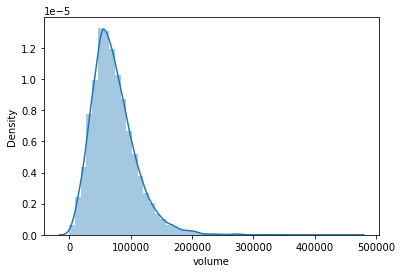

In [69]:
sns.distplot(meta_complete['volume'])

## Test

In [13]:
a = pd.DataFrame({'gene': bases}).value_counts()
a.head(50)

gene     
NCAPG        51011
RPL37        28216
MALAT1       26820
RPS28        23604
WBP1         21491
YTHDC1       20796
EEF2         20242
YTHDF2       20028
PRPF31       17299
NFIC         14405
YTHDF1       14198
SRRM2        13955
NEAT1        13661
TNPO1        13347
TSHZ1        13323
CLU          13089
TYMS         12992
RPS3         12306
ABL1         11667
RPL36A       10874
BTBD3        10779
MAZ          10508
ZBED4        10239
MTDH         10208
HNRNPA2B1    10132
ETF1          9110
KIF13A        9065
COX6C         8965
CCNT1         8762
GALNT2        8168
SLC7A5        8122
FBXO34        7916
YTHDF3        7914
CNOT1         7837
MCM2          7760
SF3B1         7643
MYL9          7464
CCM2          7412
TRMT112       7343
CRIP1         7135
KTN1          7107
DDX3X         6906
PODXL         6905
METTL3        6827
AP2B1         6573
NIPBL         6571
SLC16A1       6393
LRRC8D        6389
DYNC1H1       6307
FAM107B       6167
dtype: int64